In [1]:
#IMPORTATIONS DE BIBLIOTHEQUES
import pandas as pd
import copy
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import numpy
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import shutil




/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)


2.1.0+cu121


In [3]:
# Chargement des données

tr=pd.read_csv("/kaggle/input/projet354/Train.csv",sep=",")
test=pd.read_csv("/kaggle/input/projet354/Test.csv",sep=",")
submission_data = pd.read_csv("/kaggle/input/projet354/SampleSubmission.csv",sep=",")


In [4]:
test_data=copy.copy(test)
train=copy.copy(tr)
train.head(10)


,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast
5,id_00stp9t6m6_rgn.jpg,blast
6,id_012zxewnhx.jpg,blast
7,id_012zxewnhx_rgn.jpg,blast
8,id_0186qwq2at.jpg,healthy
9,id_0186qwq2at_rgn.jpg,healthy


In [5]:
trains=copy.copy(tr)

In [7]:
train.head()   

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


In [8]:
 test.head()

,Image_id
0,id_00vl5wvxq3.jpg
1,id_00vl5wvxq3_rgn.jpg
2,id_01hu05mtch.jpg
3,id_01hu05mtch_rgn.jpg
4,id_030ln10ewn.jpg


In [5]:
train.shape, test.shape,submission_data.shape

((5340, 2), (2290, 1), (1145, 4))

In [6]:
train.isnull().sum(),test.isnull().sum()

(Image_id    0
 Label       0
 dtype: int64,
 Image_id    0
 dtype: int64)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5340 entries, 0 to 5339
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_id  5340 non-null   object
 1   Label     5340 non-null   object
dtypes: object(2)
memory usage: 83.6+ KB


# Visualisation

In [8]:
fichiers_images = '/kaggle/input/projet354/Images'

train['images'] = train['Image_id'].apply(lambda x: Image.open(os.path.join(fichiers_images, x)))


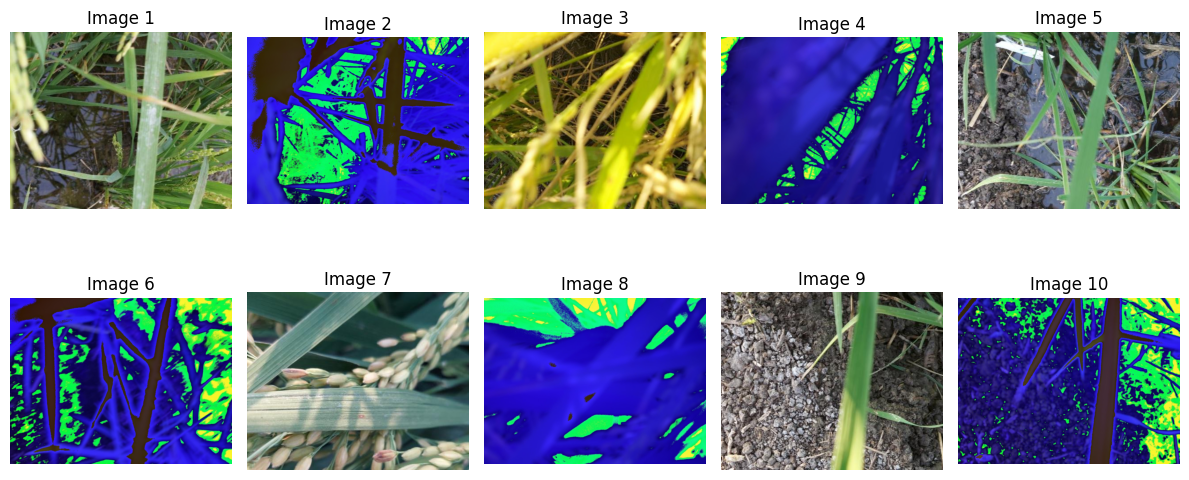

In [9]:

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for im_path, ax in zip(range(10), axes.flatten()):
    image = train['images'][im_path]

    ax.imshow(image)
    ax.set_title(f'Image {im_path + 1}')
    ax.axis('off')  
plt.tight_layout()
plt.show()


In [ ]:
 Suppression des images infrarouge.

In [10]:
train = train[~train['Image_id'].str.endswith('_rgn.jpg')]
train = train.reset_index(drop=True)
train.head(10)

,Image_id,Label,images
0,id_004wknd7qd.jpg,blast,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,id_005sitfgr2.jpg,brown,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,id_00stp9t6m6.jpg,blast,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,id_012zxewnhx.jpg,blast,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,id_0186qwq2at.jpg,healthy,<PIL.JpegImagePlugin.JpegImageFile image mode=...
5,id_01vb9vty05.jpg,brown,<PIL.JpegImagePlugin.JpegImageFile image mode=...
6,id_01z6i8am9b.jpg,blast,<PIL.JpegImagePlugin.JpegImageFile image mode=...
7,id_02lw7skww5.jpg,blast,<PIL.JpegImagePlugin.JpegImageFile image mode=...
8,id_02olqz4tf5.jpg,blast,<PIL.JpegImagePlugin.JpegImageFile image mode=...
9,id_03878to61t.jpg,brown,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [15]:
train.shape

(2670, 3)

# Statistiques des classes

Statistiques avant de couper les données en données d'entrainnement et données de validation.

In [16]:
train.groupby("Label")["images"].count()


Label
blast      1494
brown       766
healthy     410
Name: images, dtype: int64

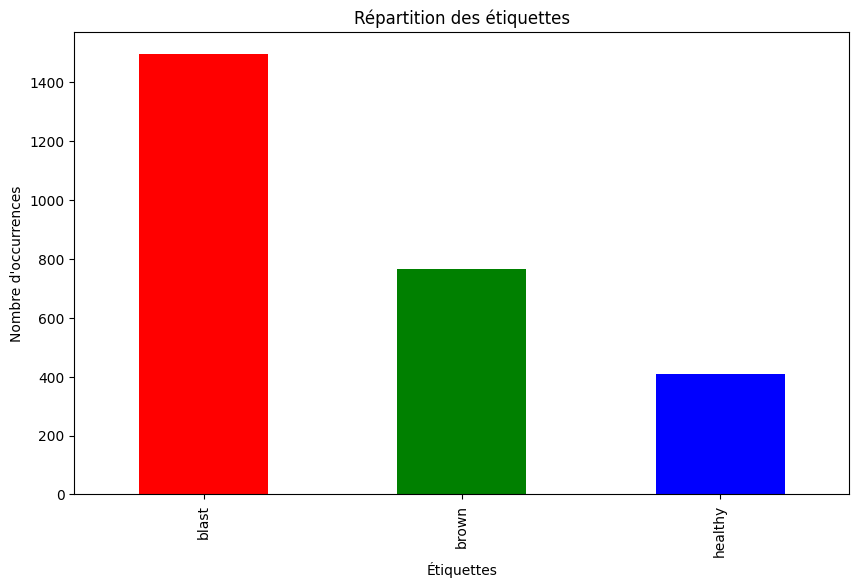

In [17]:
counts = train['Label'].value_counts()

#Diagramme à barres
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Répartition des étiquettes')
plt.xlabel('Étiquettes')
plt.ylabel('Nombre d\'occurrences')
plt.show()

Division des données train en ensembles d'entraînement et de validation


In [11]:
train_data, val_data = train_test_split(train, test_size=0.3, random_state=42)

Statistiques après découpage.


In [21]:

# Regroupement par étiquettes et comptage les données d'entrainement
counts = train_data['Label'].value_counts()
counts

Label
blast      1023
brown       549
healthy     297
Name: count, dtype: int64

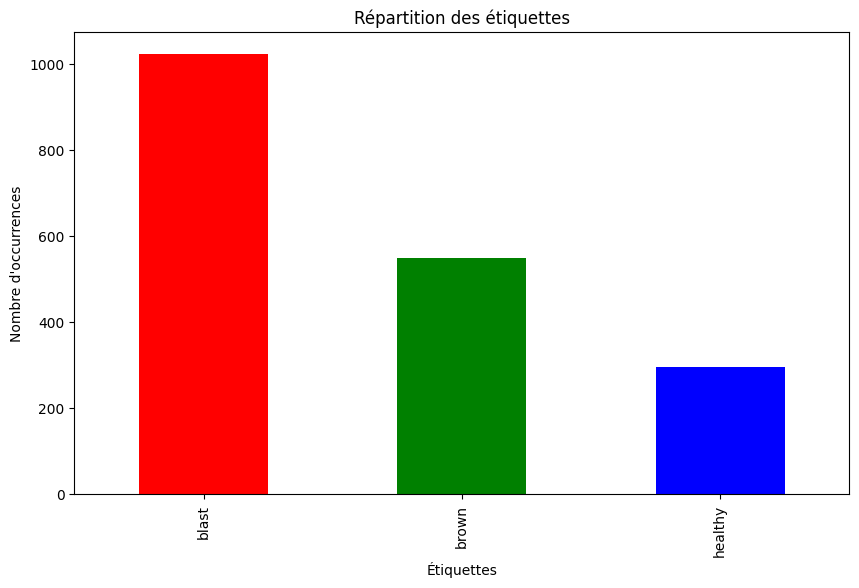

In [22]:
#Diagramme à barres
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Répartition des étiquettes')
plt.xlabel('Étiquettes')
plt.ylabel('Nombre d\'occurrences')
plt.show()

In [23]:
counts = val_data['Label'].value_counts()
counts

Label
blast      471
brown      217
healthy    113
Name: count, dtype: int64

In [8]:
train_data.head()



,Image_id,Label
2534,id_gr9qt0itps.jpg,blast
1383,id_91a69ffmc6_rgn.jpg,blast
2225,id_ewmt3dkh3k_rgn.jpg,blast
2802,id_iradxxvy4t.jpg,blast
4578,id_uqf779y69f.jpg,blast


 Parcours de toutes les images et copie dans les dossiers appropriés


In [12]:

# Chemin vers le dossier principal contenant toutes les images (sur Kaggle)
image_folder = "/kaggle/input/projet354/Images"

# Chemins des dossiers d'entraînement et de validation
train_image_folder = "/kaggle/working/train_folder"
val_image_folder = "/kaggle/working/val_folder"
test_image_folder="/kaggle/working/test_folder"

# Assurez-vous que les dossiers existent
os.makedirs(train_image_folder, exist_ok=True)
os.makedirs(val_image_folder, exist_ok=True)
os.makedirs(test_image_folder, exist_ok=True)

for idx, row in train_data.iterrows():
    image_path = os.path.join(image_folder, row["Image_id"])
    shutil.copy(image_path, os.path.join(train_image_folder, row["Image_id"]))

for idx, row in val_data.iterrows():
    image_path = os.path.join(image_folder, row["Image_id"])
    shutil.copy(image_path, os.path.join(val_image_folder, row["Image_id"]))

for idx, row in test_data.iterrows():
    image_path = os.path.join(image_folder, row["Image_id"])
    shutil.copy(image_path, os.path.join(test_image_folder, row["Image_id"]))


 Enregistrer les chemins des fichiers d'entraînement et de validation pour une utilisation ultérieure


In [ ]:
train_data.to_csv("train_processed.csv", index=False)
val_data.to_csv("val_processed.csv", index=False)
test_data.to_csv("test_processed.csv", index=False)

Mise en place de l'archicteture du reseau de neurone.

In [13]:
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = f"{self.image_folder}/{self.data.iloc[idx, 0]}"
        image = Image.open(img_name).convert('RGB')  # Assurez-vous de charger l'image en tant que PIL.Image
        label = self.data.iloc[idx, 1]
        Image_id=self.data.iloc[idx,0]
        if self.transform:
            image = self.transform(image)

        return image, label



In [14]:
image_path = "/kaggle/input/projet354/Images/id_004wknd7qd.jpg"


image = Image.open(image_path)

# Obtenir le format de l'image
image_format = image.format
resolution = image.size
print(f"Le format de l'image est : {image_format}")
print(f"La résolution de l'image est : {resolution}")

Le format de l'image est : JPEG
La résolution de l'image est : (500, 400)


 Définir les transformations d'images (redimensionnement, normalisation, etc.)


In [25]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



 Créer des instances de la classe Dataset pour l'entraînement et la validation


In [16]:
train_dataset = CustomDataset(train_data, "/kaggle/working/train_folder", transform=transform)
val_dataset = CustomDataset(val_data, "/kaggle/working/val_folder", transform=transform)
test_dataset = CustomDataset(test_data,"/kaggle/working/test_folder", transform=transform)


In [17]:
# Créer des chargeurs de données (DataLoaders)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=4,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


 Création du modèle


In [18]:
class CustomModel(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(CustomModel, self).__init__()
        # Utiliser ResNet18 pré-entraîné
        self.base_model = models.resnet18(pretrained=True)

        
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)



 Creation une instance de CustomModel

In [19]:
num_classes = len(train_data['Label'].unique())
model = CustomModel(num_classes)


/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s] 


##  Mise en place du dispositif (GPU s'il est disponible, sinon CPU)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model = CustomModel(num_classes=3)  # Remplacez 3 par le nombre de classes
model.to(device)

total_val_loss = 0.0
correct_predictions = 0
total_samples = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.1, rho=0.9, eps=1e-06)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.91)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.90, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


## Entraînement du modèle

In [21]:

# Utilisez cette fonction pour mapper les étiquettes aux indices
def map_labels_to_index(labels):
    class_to_idx = {'healthy': 0, 'blast': 1, 'brown': 2}
    default_index = 0
    mapped_labels = [class_to_idx.get(label, default_index) for label in labels]
    return torch.tensor(mapped_labels, dtype=torch.long)

# Définir le nombre d'époques
num_epochs = 20
best_val_loss = float('inf')


train_losses = []
validation_losses = []
validation_accuracy = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Assurez-vous que les tensors sont envoyés sur le bon appareil
        inputs, labels = inputs.to(device), map_labels_to_index(labels).to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Calculer la perte moyenne sur l'ensemble d'entraînement
    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Évaluer le modèle sur l'ensemble de validation
    model.eval()
    total_val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), map_labels_to_index(labels).to(device)
            outputs = model(inputs)

            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

            # Calculer la précision
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Calculer la perte moyenne sur l'ensemble de validation
    average_val_loss = total_val_loss / len(val_loader)
    validation_losses.append(average_val_loss)

      # Sauvegarder le meilleur modèle
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        torch.save(model.state_dict(), 'best_model33.pth')

    # Calculer la précision
    accuracy = correct_predictions / total_samples
    validation_accuracy.append(accuracy)

    # Afficher les résultats au fur et à mesure
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Validation Loss: {average_val_loss}, Accuracy: {accuracy}')


Epoch 1/20, Train Loss: 0.670609590865798, Validation Loss: 0.3349743431004194, Accuracy: 0.8826466916354557
Epoch 2/20, Train Loss: 0.17398097984871622, Validation Loss: 0.263177250046283, Accuracy: 0.8976279650436954
Epoch 3/20, Train Loss: 0.06366628528398982, Validation Loss: 0.2321985873322074, Accuracy: 0.9176029962546817
Epoch 4/20, Train Loss: 0.022462999850700972, Validation Loss: 0.22592573303084534, Accuracy: 0.9176029962546817
Epoch 5/20, Train Loss: 0.013115019949894967, Validation Loss: 0.21470213246245223, Accuracy: 0.9238451935081149
Epoch 6/20, Train Loss: 0.008751426821464073, Validation Loss: 0.22494101743751133, Accuracy: 0.9288389513108615
Epoch 7/20, Train Loss: 0.008455489739436278, Validation Loss: 0.2360296848212154, Accuracy: 0.9238451935081149
Epoch 8/20, Train Loss: 0.009468257608744552, Validation Loss: 0.27672156083728905, Accuracy: 0.9001248439450686
Epoch 9/20, Train Loss: 0.010508699239018546, Validation Loss: 0.24046599619144288, Accuracy: 0.9225967540

Representation graphique

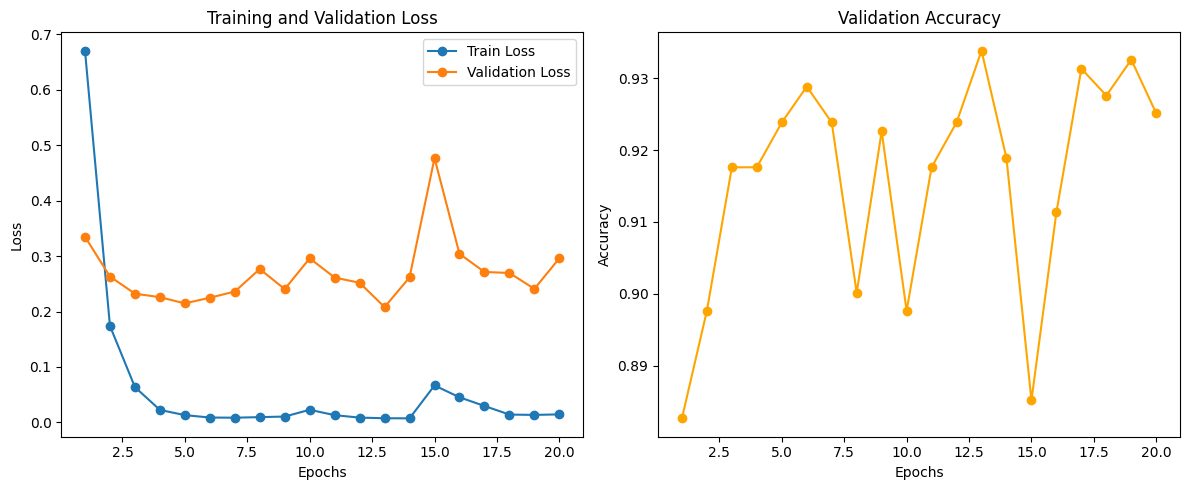

In [22]:
import matplotlib.pyplot as plt

# Époques
epochs = range(1, 21)

# Tracer les courbes
plt.figure(figsize=(12, 5))

# Courbe de perte d'entraînement
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Courbe de précision de validation
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()


# TEST

In [29]:
all_preds=[]
all_labels=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Charger le modèle entraîné avec les meilleurs poids

model.load_state_dict(torch.load('/kaggle/working/best_model33.pth'))
#model.to('cuda')
model.eval()

predictions = []


with torch.no_grad():
    for index, row in test.iterrows():
        if "_rgn.jpg" in row['Image_id']:
            continue

        image_path = os.path.join('/kaggle/working/test_folder', row['Image_id'])
        
        image = Image.open(image_path).convert('RGB')
        image = transform(image)
        image = image.unsqueeze(0)
        
        #image = image.to('cuda')

        # prédiction
        output = model(image)

        # les probabilités
        probs = torch.nn.functional.softmax(output, dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Récupération des probabilités
        prob_blast, prob_brown, prob_healthy = probs[0]

        # Ajouter les résultats à la liste
        predictions.append({
            'Image_id': row['Image_id'],
            'blast': prob_blast.item(),
            'brown': prob_brown.item(),
            'healthy': prob_healthy.item()
        })

# DataFrame des prédictions 
SampleSubmission = pd.DataFrame(predictions)


SampleSubmission.to_csv('/kaggle/working/SampleSubmission0.csv', index=False)


KeyboardInterrupt: 

Fin